# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Carga e preparação inicial dos dados

Dados obtidos em: https://br.investing.com/indices/bovespa-historical-data

In [2]:
# Carga do CSV
data = pd.read_csv('dados/ibovespa-200407-202406.csv',
                   usecols=['Data', 'Último'], dtype=str)

# Renomeando as variáveis
data.columns = ['date', 'closing']

# Convertendo a coluna date para o tipo date
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

# Limpeza dos caracteres para conversão para o tipo float
data['closing'] = data['closing'].str.replace('.', '').astype(float)

# Garantindo a ordenação
data = data.sort_values('date', ignore_index=True)

In [3]:
data.to_csv('dataset.csv', index=False)

# Descrição dos dados

**Variáveis:**

|Variável|Descrição|
|-|-|
|date|Data do pregão|
|closing|Valor de encerramento do pregão|

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     4951 non-null   datetime64[ns]
 1   closing  4951 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 77.5 KB


In [5]:
data.describe(include=np.number)

,closing
count,4951.000000
mean,69468.257322
std,28556.985815
min,20887.000000
25%,50443.000000
50%,61923.000000
75%,95429.500000
max,134194.000000


# Modelo

In [6]:
# Períodos de previsão
periods = 14

In [7]:
# Preparando os dados para o Prophet
df = data[:-periods]
df.columns = ['ds', 'y']

In [8]:
# Inicializando o modelo
model = Prophet()
model.fit(df[['ds', 'y']])

11:37:06 - cmdstanpy - INFO - Chain [1] start processing
11:37:06 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Previsão
future = model.make_future_dataframe(periods=periods)
forecast = model.predict(future)

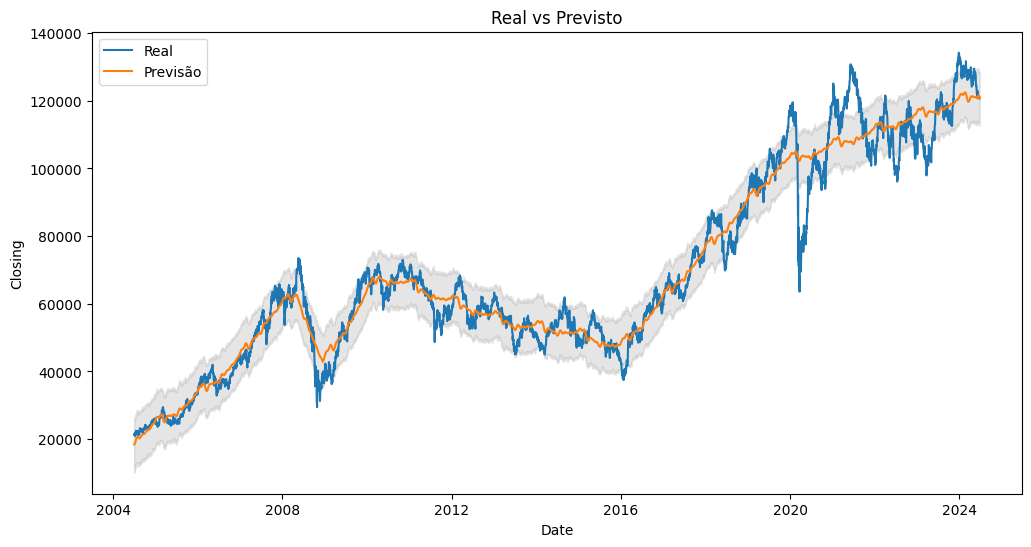

In [10]:
# Comparação entre real e previsto
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Real')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão')
plt.fill_between(forecast['ds'], forecast['yhat_lower'],
                 forecast['yhat_upper'], color='gray', alpha=0.2)
plt.title('Real vs Previsto')
plt.xlabel('Date')
plt.ylabel('Closing')
plt.legend()
plt.show()

# Validação

In [11]:
# Criação do dataset para validação
validation = data.merge(forecast[['ds', 'yhat']],
                        left_on='date', right_on='ds')

# Arredondamento do fechamento previsto
validation['closing_forecast'] = validation['yhat'].round()

# Remoção da primeira linha do dataset, que não contém o cálculo da variação
validation.dropna(inplace=True, ignore_index=True)

# Remoção das colunas duplicadas e já tratadas
validation.drop(['ds', 'yhat'], axis=1, inplace=True)

In [12]:
# Métricas
mae = mean_absolute_error(validation['closing'],
                          validation['closing_forecast'])
mape = mean_absolute_percentage_error(validation['closing'],
                                      validation['closing_forecast'])
accuracy = (1 - mape) * 100

print('Métricas:',
      '\n', 'MAE: ', round(mae, 2),
      '\n', 'MAPE: ', round(mape * 100, 2), '%',
      '\n', 'Precisão: ', round(accuracy, 2), '%')

Métricas: 
 MAE:  4244.16 
 MAPE:  6.28 % 
 Precisão:  93.72 %


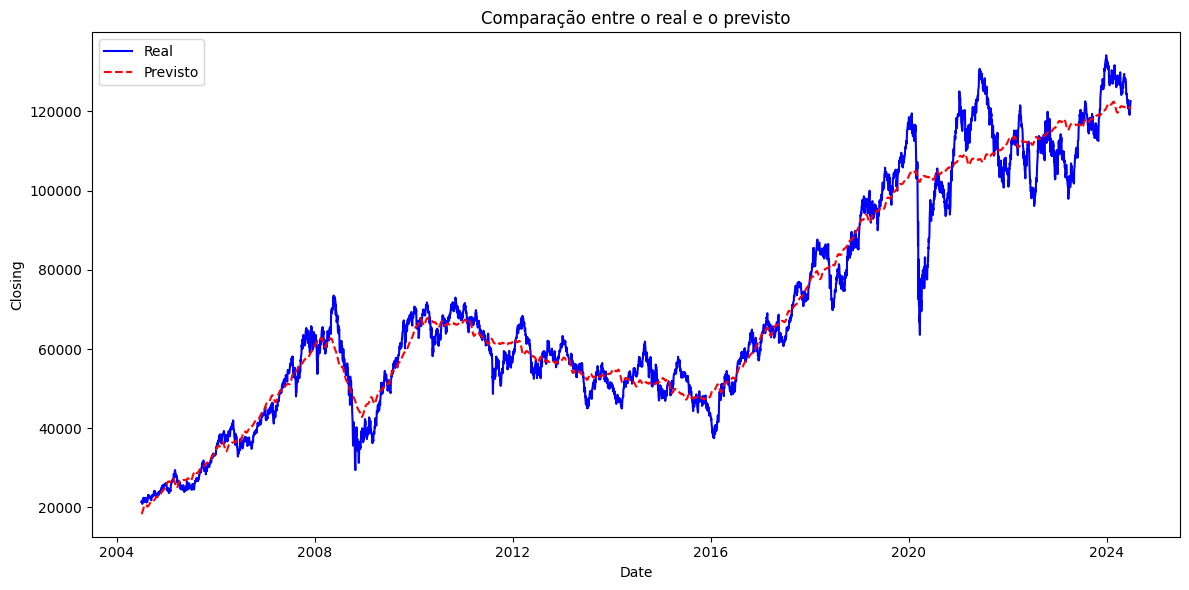

In [13]:
# Real x Previsto
plt.figure(figsize=(12, 6))
plt.plot(validation['date'], validation['closing'], label='Real', color='blue')
plt.plot(validation['date'], validation['closing_forecast'], label='Previsto',
         color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Closing')
plt.title('Comparação entre o real e o previsto')
plt.legend()
plt.tight_layout()
plt.show()